# Train VAE Model on Kerala eBird Data

This notebook trains a Variational Autoencoder on Kerala eBird checklist data and extracts embeddings for all checklists.

**Outputs:**
1. Trained VAE model → `models/vae_kerala_YYYYMMDD.pth`
2. All embeddings → `data/processed/kerala_embeddings_YYYYMMDD.npz` (with sampling IDs)
3. Training history plots

**Configuration:**
- Data: Kerala eBird (1 million observations)
- Architecture: 512 hidden dim, 16 latent dim
- Training: 200 epochs, batch size 512, lr=1e-4

## Setup

In [1]:
import sys
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
PyTorch version: 2.8.0+cpu
CUDA available: False


In [2]:
# Import backbone modules
from src.data import load_ebird_data, EBirdPreprocessor
from src.models import VariationalAutoencoder
from src.training import train_variational_autoencoder, get_device, save_model_for_inference
from src.inference import EmbeddingExtractor, save_embeddings

print('✓ All modules imported successfully')

✓ All modules imported successfully


## Configuration

In [3]:
# Training configuration
CONFIG = {
    'nrows': 1_000_000,           # Number of observations to load
    'latent_dim': 16,             # Latent embedding dimension
    'hidden_dim': 512,            # Hidden layer dimension
    'num_epochs': 200,            # Training epochs
    'batch_size': 512,            # Batch size
    'learning_rate': 1e-4,        # Learning rate
    'noise_std': 0.1,             # Noise augmentation std
    'train_split': 0.8,           # Train/val split ratio
    'device': 'auto',             # 'auto', 'cuda', or 'cpu'
    'save_every': 20,             # Save checkpoint every N epochs
    'print_every': 5              # Print progress every N epochs
}

# Generate timestamp for saving
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M')

print('Configuration:')
for key, value in CONFIG.items():
    print(f'  {key}: {value}')
print(f'\nTimestamp: {TIMESTAMP}')

Configuration:
  nrows: 1000000
  latent_dim: 16
  hidden_dim: 512
  num_epochs: 200
  batch_size: 512
  learning_rate: 0.0001
  noise_std: 0.1
  train_split: 0.8
  device: auto
  save_every: 20
  print_every: 5

Timestamp: 20251206_2156


## 1. Load and Preprocess Data

In [4]:
# Load Kerala eBird data
data_path = project_root / 'data' / 'raw' / 'ebd_IN-KL_smp_relSep-2025.txt'

print(f'Loading data from: {data_path}')
print(f'Loading {CONFIG["nrows"]:,} observations...')

df = load_ebird_data(str(data_path), nrows=CONFIG['nrows'])

print(f'\n✓ Loaded {len(df):,} observations')
print(f'  Unique checklists: {df["SAMPLING EVENT IDENTIFIER"].nunique():,}')
print(f'  Unique species: {df["COMMON NAME"].nunique():,}')
print(f'  Date range: {df["OBSERVATION DATE"].min()} to {df["OBSERVATION DATE"].max()}')

Loading data from: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\raw\ebd_IN-KL_smp_relSep-2025.txt
Loading 1,000,000 observations...
✓ Loaded eBird data from: ebd_IN-KL_smp_relSep-2025.txt
  Rows: 1,000,000
  Columns: 53
  (Limited to first 1,000,000 rows)

✓ Loaded 1,000,000 observations
  Unique checklists: 75,093
  Unique species: 680
  Date range: 1874-04-27 to 2016-08-31


In [5]:
# Preprocess data
print('Preprocessing data...')

# Get the matrix with checklist IDs before they're dropped
from src.data.preprocessor import create_species_matrix
matrix_with_ids, species_list = create_species_matrix(
    df,
    min_species_observations=None,
    min_checklist_species=None,
    apply_quality_filters=True
)

# Save the sampling event IDs before preprocessing drops them
sampling_event_ids = matrix_with_ids['SAMPLING EVENT IDENTIFIER'].values

# Now drop the ID column for the model
processed_df = matrix_with_ids.drop(columns=['SAMPLING EVENT IDENTIFIER'])

print(f'\n✓ Preprocessed to species matrix')
print(f'  Checklists: {processed_df.shape[0]:,}')
print(f'  Species (features): {processed_df.shape[1]:,}')
print(f'  Data sparsity: {(processed_df.values == 0).sum() / processed_df.size:.2%}')
print(f'  Sampling event IDs saved: {len(sampling_event_ids):,}')

Preprocessing data...
Input data: 1,000,000 observations
  Unique checklists: 75,093
  Unique species: 680

Applying quality filters...
  After CATEGORY='species': 941,685 observations (58,315 removed)
  After OBSERVATION TYPE filter: 868,317 observations (73,368 removed)
  After ALL SPECIES REPORTED=1: 843,461 observations (24,856 removed)

✓ Quality filters applied: 1,000,000 → 843,461 observations
  Removed: 156,539 (15.7%)

Filtered data:
  Unique checklists: 64,895
  Unique species: 470

Pivoting data to create species matrix...
✓ Initial matrix: 64,895 checklists × 470 species

✓ Final matrix: 64,895 checklists × 470 species

✓ Preprocessed to species matrix
  Checklists: 64,895
  Species (features): 470
  Data sparsity: 97.23%
  Sampling event IDs saved: 64,895


## 2. Prepare Data Loaders

In [6]:
# Train/validation split
train_size = int(CONFIG['train_split'] * len(processed_df))
val_size = len(processed_df) - train_size

train_data = torch.FloatTensor(processed_df.iloc[:train_size].values)
val_data = torch.FloatTensor(processed_df.iloc[train_size:].values)

print(f'Data split:')
print(f'  Train: {len(train_data):,} checklists')
print(f'  Val:   {len(val_data):,} checklists')
print(f'  Ratio: {train_size/len(processed_df):.1%} / {val_size/len(processed_df):.1%}')

Data split:
  Train: 51,916 checklists
  Val:   12,979 checklists
  Ratio: 80.0% / 20.0%


In [7]:
# Create simple dataset class (returns tensors directly, not tuples)
class SimpleDataset:
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = SimpleDataset(train_data)
val_dataset = SimpleDataset(val_data)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False
)

print(f'\n✓ Data loaders created')
print(f'  Train batches: {len(train_loader)}')
print(f'  Val batches: {len(val_loader)}')


✓ Data loaders created
  Train batches: 102
  Val batches: 26


## 3. Create Model

In [8]:
# Get device
if CONFIG['device'] == 'auto':
    device = get_device()
else:
    device = CONFIG['device']
    print(f'Using device: {device}')

# Create model
input_dim = processed_df.shape[1]

model = VariationalAutoencoder(
    input_dimension=input_dim,
    latent_dimension=CONFIG['latent_dim'],
    hidden_dimension=CONFIG['hidden_dim']
)
model = model.to(device)

print(f'\n✓ Model created')
print(f'  Input dimension: {input_dim}')
print(f'  Latent dimension: {CONFIG["latent_dim"]}')
print(f'  Hidden dimension: {CONFIG["hidden_dim"]}')
print(f'  Device: {device}')

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'  Total parameters: {total_params:,}')

✓ Using CPU

✓ Model created
  Input dimension: 470
  Latent dimension: 16
  Hidden dimension: 512
  Device: cpu
  Total parameters: 1,558,006

✓ Model created
  Input dimension: 470
  Latent dimension: 16
  Hidden dimension: 512
  Device: cpu
  Total parameters: 1,558,006


## 4. Train Model

In [9]:
# Create checkpoint directory
checkpoint_dir = project_root / 'checkpoints' / f'vae_kerala_{TIMESTAMP}'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f'Checkpoint directory: {checkpoint_dir}')
print(f'\nStarting training for {CONFIG["num_epochs"]} epochs...\n')
print('='*80)

Checkpoint directory: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\checkpoints\vae_kerala_20251206_2156

Starting training for 200 epochs...



In [10]:
# Train
history = train_variational_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=CONFIG['num_epochs'],
    learning_rate=CONFIG['learning_rate'],
    noise_std=CONFIG['noise_std'],
    device=device,
    print_every=CONFIG['print_every'],
    checkpoint_dir=str(checkpoint_dir),
    save_every=CONFIG['save_every']
)

print('\n' + '='*80)
print('✓ Training complete!')
print(f'  Final train loss: {history["train_loss"][-1]:.4f}')
print(f'  Final val loss: {history["val_loss"][-1]:.4f}')

Checkpoints will be saved to: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\checkpoints\vae_kerala_20251206_2156

Starting training on cpu...
Epochs: 200, Learning rate: 0.0001, Noise std: 0.1
Train batches: 102, Val batches: 26
--------------------------------------------------------------------------------
Epoch   1/200 | Train Loss: 133.0872 (Recon: 131.6460, KL: 1.4411) | Val Loss: 44.3000 (Recon: 44.1902, KL: 0.1097)
Epoch   5/200 | Train Loss: 39.9121 (Recon: 38.9418, KL: 0.9702) | Val Loss: 40.1735 (Recon: 39.6213, KL: 0.5523)
Epoch  10/200 | Train Loss: 39.5873 (Recon: 38.5603, KL: 1.0271) | Val Loss: 40.3261 (Recon: 39.7083, KL: 0.6178)
Epoch  15/200 | Train Loss: 36.1277 (Recon: 34.1565, KL: 1.9712) | Val Loss: 38.6027 (Recon: 37.5592, KL: 1.0435)
Epoch  20/200 | Train Loss: 34.9621 (Recon: 32.8303, KL: 2.1318) | Val Loss: 37.7969 (Recon: 36.5655, KL: 1.2314)
  → Saved checkpoint: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\checkpoints\vae_kerala_2025120

## 5. Plot Training Curves

In [11]:
history.keys()

dict_keys(['train_loss', 'train_recon_loss', 'train_kl_loss', 'val_loss', 'val_recon_loss', 'val_kl_loss'])

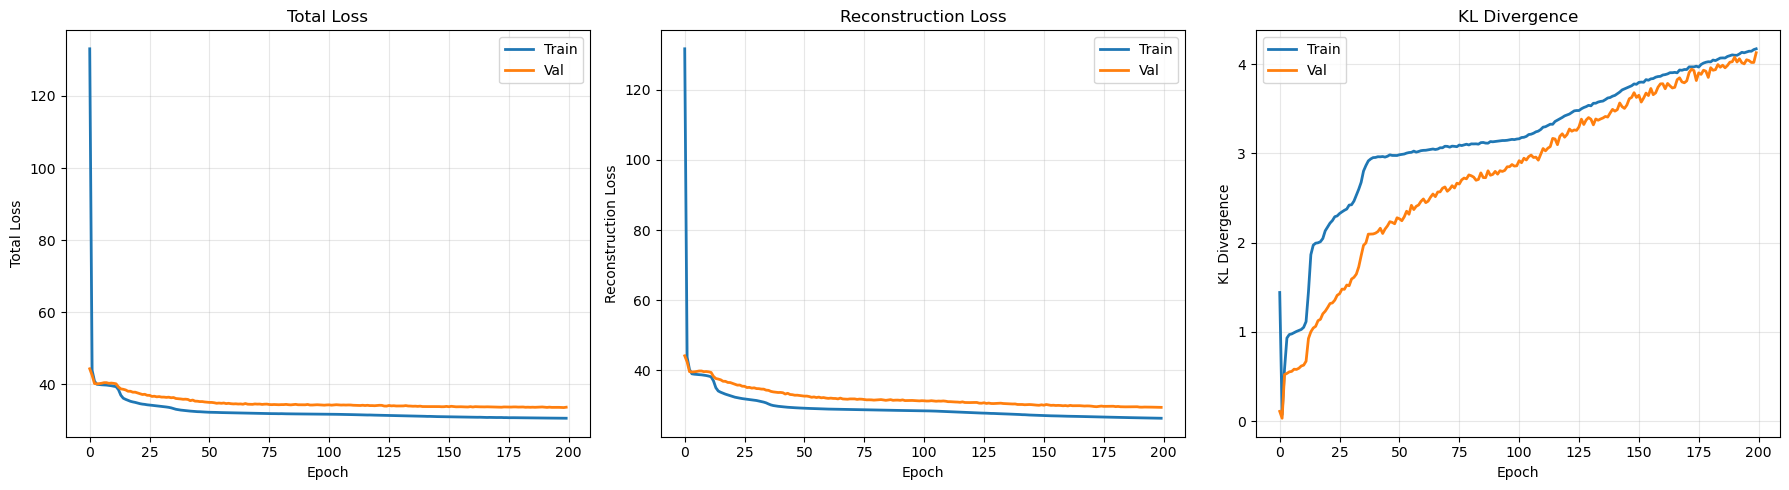

✓ Saved training curves to c:\Users\Arnav\Documents\Python Scripts\bird embeddings\checkpoints\vae_kerala_20251206_2156\training_curves.png


In [12]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history['train_recon_loss'], label='Train', linewidth=2)
axes[1].plot(history['val_recon_loss'], label='Val', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL divergence
axes[2].plot(history['train_kl_loss'], label='Train', linewidth=2)
axes[2].plot(history['val_kl_loss'], label='Val', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'✓ Saved training curves to {checkpoint_dir / "training_curves.png"}')

## 6. Save Final Model

In [13]:
# Save model for inference
model_save_path = project_root / 'models' / f'vae_kerala_{TIMESTAMP}.pth'

save_model_for_inference(
    model=model,
    filepath=str(model_save_path),
    input_dim=input_dim,
    latent_dim=CONFIG['latent_dim'],
    hidden_dims=[CONFIG['hidden_dim']],
    metadata={
        'dataset': 'Kerala eBird',
        'n_observations': CONFIG['nrows'],
        'n_checklists': len(processed_df),
        'n_species': input_dim,
        'num_epochs': CONFIG['num_epochs'],
        'batch_size': CONFIG['batch_size'],
        'learning_rate': CONFIG['learning_rate'],
        'final_train_loss': float(history['train_loss'][-1]),
        'final_val_loss': float(history['val_loss'][-1]),
        'timestamp': TIMESTAMP
    }
)

print(f'\n✓ Model ready for inference at:\n  {model_save_path}')

✓ Model saved for inference: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\models\vae_kerala_20251206_2156.pth
  Input dim: 470, Latent dim: 16
  Hidden dims: [512]

✓ Model ready for inference at:
  c:\Users\Arnav\Documents\Python Scripts\bird embeddings\models\vae_kerala_20251206_2156.pth


## 7. Extract Embeddings for All Checklists

In [14]:
print('Extracting embeddings for all checklists...')
print(f'Processing {len(processed_df):,} checklists...\n')

# Create extractor from trained model
extractor = EmbeddingExtractor(str(model_save_path), device=device)

# Extract embeddings (deterministic mode - use mean)
embeddings = extractor.extract_embeddings(
    processed_df, 
    use_mean=True, 
    batch_size=CONFIG['batch_size']
)

print(f'✓ Extracted embeddings')
print(f'  Shape: {embeddings.shape}')
print(f'  Min: {embeddings.min():.4f}')
print(f'  Max: {embeddings.max():.4f}')
print(f'  Mean: {embeddings.mean():.4f}')
print(f'  Std: {embeddings.std():.4f}')

Extracting embeddings for all checklists...
Processing 64,895 checklists...

✓ Model loaded from c:\Users\Arnav\Documents\Python Scripts\bird embeddings\models\vae_kerala_20251206_2156.pth
  Input dim: 470, Latent dim: 16, Hidden dim: 512, Device: cpu
✓ Extracted embeddings
  Shape: (64895, 16)
  Min: -4.2692
  Max: 5.0895
  Mean: 0.0046
  Std: 0.4742


## 8. Save Embeddings with Sampling IDs

In [15]:
# Save embeddings to processed data folder
embeddings_save_path = project_root / 'data' / 'processed' / f'kerala_embeddings_{TIMESTAMP}.npz'

# Ensure processed directory exists
embeddings_save_path.parent.mkdir(parents=True, exist_ok=True)

# Save with metadata
np.savez_compressed(
    embeddings_save_path,
    embeddings=embeddings,
    sampling_event_ids=sampling_event_ids,
    # Metadata
    latent_dim=CONFIG['latent_dim'],
    n_checklists=len(processed_df),
    n_species=input_dim,
    model_path=str(model_save_path.name),
    timestamp=TIMESTAMP
)

print(f'✓ Saved embeddings to:\n  {embeddings_save_path}')
print(f'\nFile size: {embeddings_save_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved embeddings to:
  c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\processed\kerala_embeddings_20251206_2156.npz

File size: 3.03 MB

File size: 3.03 MB


## 9. Summary

In [16]:
print('='*80)
print('TRAINING COMPLETE')
print('='*80)
print(f'\n📊 Data:')
print(f'   Observations loaded: {CONFIG["nrows"]:,}')
print(f'   Checklists processed: {len(processed_df):,}')
print(f'   Species (features): {input_dim}')
print(f'\n🧠 Model:')
print(f'   Architecture: {input_dim} → {CONFIG["hidden_dim"]} → {CONFIG["latent_dim"]} → {CONFIG["hidden_dim"]} → {input_dim}')
print(f'   Parameters: {total_params:,}')
print(f'   Epochs trained: {CONFIG["num_epochs"]}')
print(f'\n📈 Performance:')
print(f'   Final train loss: {history["train_loss"][-1]:.4f}')
print(f'   Final val loss: {history["val_loss"][-1]:.4f}')
print(f'\n💾 Outputs:')
print(f'   Model: {model_save_path.name}')
print(f'   Embeddings: {embeddings_save_path.name}')
print(f'   Training curves: {checkpoint_dir / "training_curves.png"}')
print(f'   Checkpoints: {checkpoint_dir}/')
print(f'\n✨ Ready for analysis!')
print('='*80)

TRAINING COMPLETE

📊 Data:
   Observations loaded: 1,000,000
   Checklists processed: 64,895
   Species (features): 470

🧠 Model:
   Architecture: 470 → 512 → 16 → 512 → 470
   Parameters: 1,558,006
   Epochs trained: 200

📈 Performance:
   Final train loss: 30.5656
   Final val loss: 33.6237

💾 Outputs:
   Model: vae_kerala_20251206_2156.pth
   Embeddings: kerala_embeddings_20251206_2156.npz
   Training curves: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\checkpoints\vae_kerala_20251206_2156\training_curves.png
   Checkpoints: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\checkpoints\vae_kerala_20251206_2156/

✨ Ready for analysis!


## Next Steps

You can now use the embeddings in any project:

```python
# Load embeddings
data = np.load('data/processed/kerala_embeddings_YYYYMMDD_HHMM.npz')
embeddings = data['embeddings']
sampling_ids = data['sampling_event_ids']

# Use in your analysis
# ...
```

**Project ideas:**
- District prediction
- Species clustering
- Temporal patterns
- Hotspot similarity